In [1]:
import yfinance as yf
import pandas as pd

# Define the tickers for TSLA, BND, and SPY
tickers = ["TSLA", "BND", "SPY"]

# Download data from Yahoo Finance for the selected tickers
data = yf.download(tickers, start="2015-01-01", end="2023-01-01")['Adj Close']
data.columns = ['TSLA', 'BND', 'SPY']  # Rename columns for clarity
data.head()


[*********************100%***********************]  3 of 3 completed


,TSLA,BND,SPY
Date,,,
2015-01-02 00:00:00+00:00,63.358723,173.173767,14.620667
2015-01-05 00:00:00+00:00,63.542759,170.046310,14.006000
2015-01-06 00:00:00+00:00,63.726715,168.444672,14.085333
2015-01-07 00:00:00+00:00,63.765045,170.543671,14.063333
2015-01-08 00:00:00+00:00,63.665401,173.569992,14.041333


In [2]:
print(data.info())  # Check data types and missing values
print(data.describe())  # Summary statistics


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 00:00:00+00:00 to 2022-12-30 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2014 non-null   float64
 1   BND     2014 non-null   float64
 2   SPY     2014 non-null   float64
dtypes: float64(3)
memory usage: 62.9 KB
None
              TSLA          BND          SPY
count  2014.000000  2014.000000  2014.000000
mean     70.047949   273.957764    88.662189
std       5.329670    85.302950   108.557913
min      62.637615   157.328598     9.578000
25%      65.995953   198.774586    16.217167
50%      67.568306   254.202072    21.881333
75%      75.097780   349.701164   182.904999
max      79.812935   458.720306   409.970001


In [3]:
# Forward fill and backward fill for any missing values
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)


C:\Users\dell\AppData\Local\Temp\ipykernel_10204\2776422681.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_10204\2776422681.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)


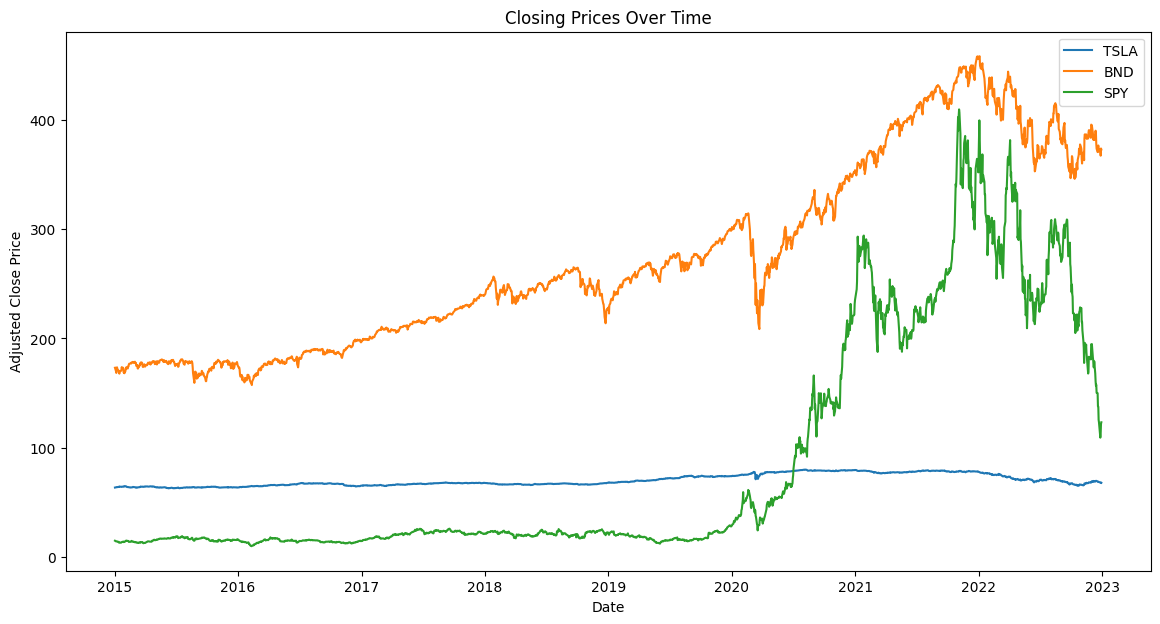

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for col in data.columns:
    plt.plot(data.index, data[col], label=col)
plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()


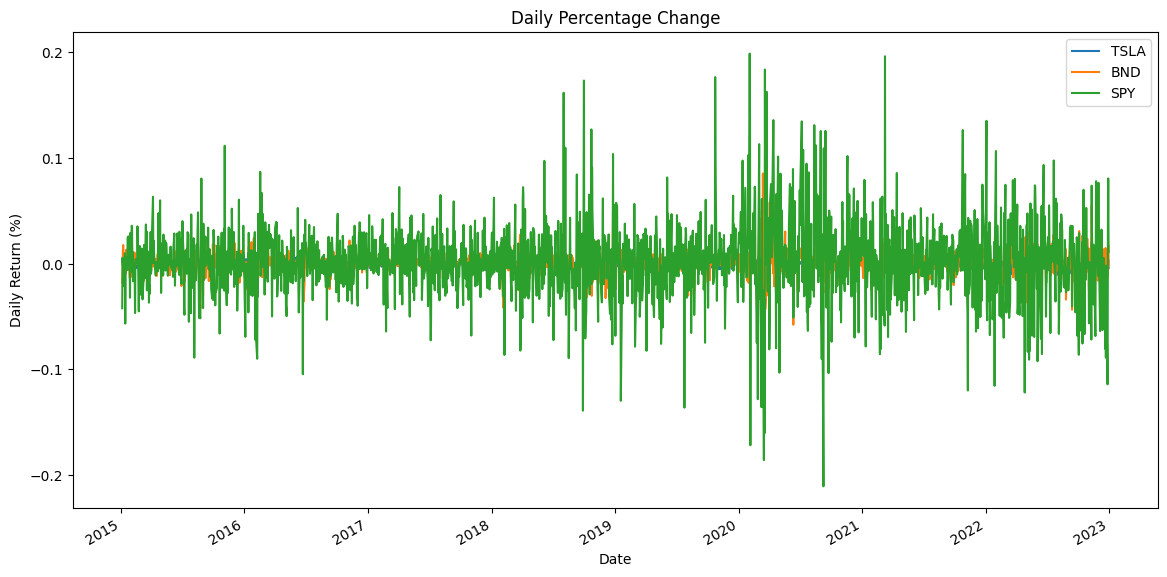

In [7]:
daily_returns = data.pct_change().dropna()  # Daily percentage change
daily_returns.plot(figsize=(14, 7), title="Daily Percentage Change", xlabel="Date", ylabel="Daily Return (%)")
plt.show()


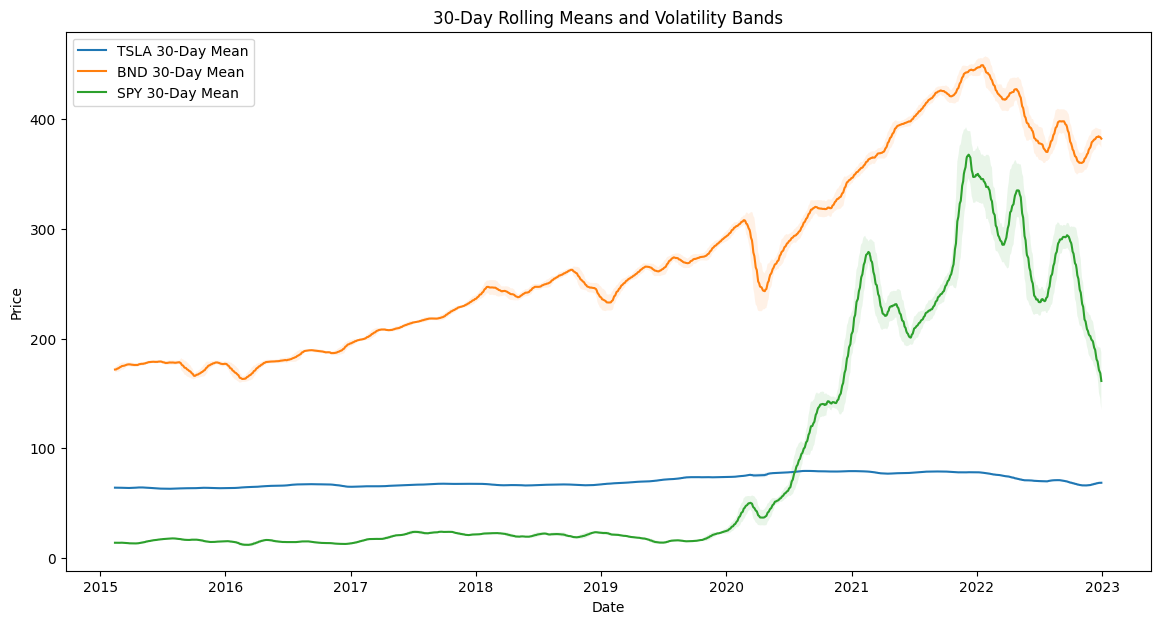

In [8]:
# Calculate 30-day rolling means and standard deviations
rolling_mean = data.rolling(window=30).mean()
rolling_std = data.rolling(window=30).std()

plt.figure(figsize=(14, 7))
for col in data.columns:
    plt.plot(rolling_mean.index, rolling_mean[col], label=f'{col} 30-Day Mean')
    plt.fill_between(rolling_std.index, (rolling_mean[col] - rolling_std[col]), 
                     (rolling_mean[col] + rolling_std[col]), alpha=0.1)
plt.title("30-Day Rolling Means and Volatility Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


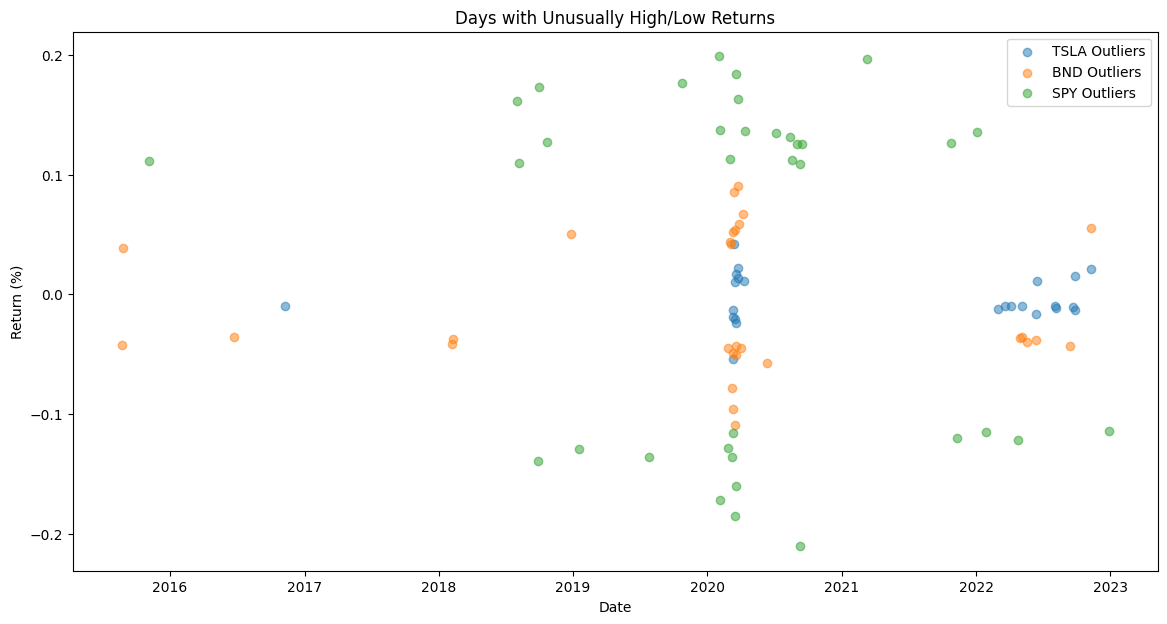

In [9]:
# Identify outliers based on daily returns
outliers = daily_returns[(daily_returns > daily_returns.mean() + 3*daily_returns.std()) |
                         (daily_returns < daily_returns.mean() - 3*daily_returns.std())]

plt.figure(figsize=(14, 7))
for col in outliers.columns:
    plt.scatter(outliers.index, outliers[col], label=f'{col} Outliers', alpha=0.5)
plt.title("Days with Unusually High/Low Returns")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.show()


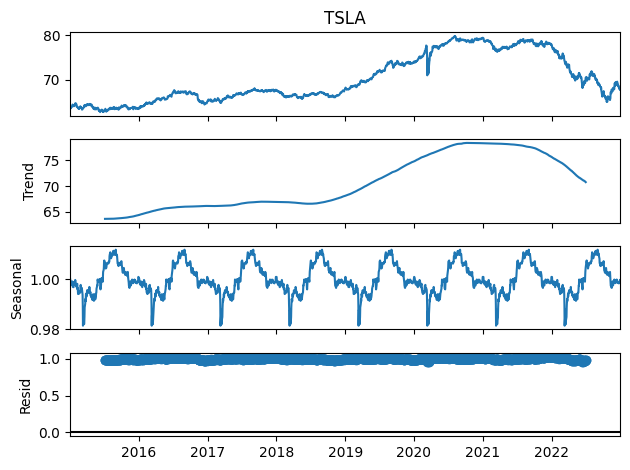

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose TSLA's closing prices as an example
decomposition = seasonal_decompose(data['TSLA'], model='multiplicative', period=252)
decomposition.plot()
plt.show()


In [11]:
# 5% VaR assuming normal distribution
var_95 = daily_returns.quantile(0.05)
print("95% VaR for each asset:\n", var_95)


95% VaR for each asset:
 TSLA   -0.004331
BND    -0.017932
SPY    -0.051401
Name: 0.05, dtype: float64


In [12]:
# Assume a risk-free rate of 0 for simplicity
sharpe_ratio = (daily_returns.mean() * 252) / (daily_returns.std() * (252**0.5))
print("Sharpe Ratio for each asset:\n", sharpe_ratio)


Sharpe Ratio for each asset:
 TSLA    0.188414
BND     0.609684
SPY     0.753569
dtype: float64


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch data
ticker = 'TSLA'
data = yf.download(ticker, start='2015-01-01', end='2024-10-31')
data = data[['Close']]  # Only use closing price
data.columns = [ticker]  # Rename column to ticker symbol

# Check for missing values and fill if needed
data = data.fillna(method='ffill')

# Train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


[*********************100%***********************]  1 of 1 completed
C:\Users\dell\AppData\Local\Temp\ipykernel_7772\2854395476.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [2]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
p, d, q = 5, 1, 0  # These parameters can be tuned
model_arima = ARIMA(train, order=(p, d, q))
fitted_arima = model_arima.fit()

# Forecast
forecast_arima = fitted_arima.forecast(steps=len(test))


c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an int

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
p, d, q = 1, 1, 1  # Autoregressive, differencing, and moving average orders
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters and cycle length

model_sarima = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
fitted_sarima = model_sarima.fit()

# Forecast
forecast_sarima = fitted_sarima.forecast(steps=len(test))


c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without

In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare data for LSTM (60 time steps as input)
X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

# Compile and train the LSTM model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, batch_size=32, epochs=10)

# Prepare test data for predictions
X_test, y_test = [], []
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
    y_test.append(test_scaled[i, 0])

X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Forecast
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)


Epoch 1/10


c:\Users\dell\GMF-Financial-Analysis\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0210
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0010
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.4425e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.3612e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.2176e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.0560e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.3712e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.3472e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.7703e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.4835e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [1]:
from pmdarima import auto_arima

# Find best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True, stepwise=True)
print(auto_model.order)  # Best p, d, q parameters for ARIMA

# Find best SARIMA parameters
auto_model_seasonal = auto_arima(train, seasonal=True, m=12, trace=True, stepwise=True)
print(auto_model_seasonal.order, auto_model_seasonal.seasonal_order)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation metrics
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred, squared=False)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

# Evaluate ARIMA predictions
mae_arima, rmse_arima, mape_arima = evaluate_model(test, forecast_arima)
print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}")

# Evaluate SARIMA predictions
mae_sarima, rmse_sarima, mape_sarima = evaluate_model(test, forecast_sarima)
print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")

# Evaluate LSTM predictions
mae_lstm, rmse_lstm, mape_lstm = evaluate_model(test.values[60:], predictions_lstm)
print(f"LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}")


NameError: name 'test' is not defined

In [ ]:
# ARIMA Future forecast
future_forecast_arima = fitted_arima.get_forecast(steps=30).predicted_mean

# SARIMA Future forecast
future_forecast_sarima = fitted_sarima.get_forecast(steps=30).predicted_mean


In [ ]:
# Prepare input for LSTM forecasting
last_60_days = test_scaled[-60:]
X_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Predict next 30 days
future_forecast_lstm = []
for _ in range(30):
    pred = model_lstm.predict(X_future)
    future_forecast_lstm.append(pred[0, 0])
    X_future = np.append(X_future[:, 1:, :], [[pred]], axis=1)

# Transform back to original scale
future_forecast_lstm = scaler.inverse_transform(np.array(future_forecast_lstm).reshape(-1, 1))
